In [1]:
import sys
sys.path.append('/home/psimmerl/mds_analysis')

import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor
import numba as nb

import awkward as ak
# import uproot as upr

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from histo_skim import (
    create_hists,
    ROOT_ERROR_LEVEL,
    DATA_VERSION,
    LUMI,
    FN_MC,
    FN_R3,
    T2_OUT_DIR,
    T2_DATA_DIR,
    LOCAL_OUT_DIR,
    LOCAL_DATA_DIR,
    OUT_DIR,
    DATA_DIR,
    gc,
    ABCD_DTSIZE,
    ABCD_DPHI,
    TOP_MARGIN,
    BOT_MARGIN,
    CUTS,
)

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier

# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root" #! BROKEN
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root" #! BROKEN
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root"
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root"

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #

Welcome to JupyROOT 6.30/02


In [2]:
N_EVENTS = -1
CUTS = [
    "match",
    "HLT", #! Loading TBranch HLTDecision causes memory overflow so I use second precut TTree
    # "CSC&DT>0",
    "L1",
    "CSCIT",
    "DTIT",
    "MET",
    # "ME11/12",
    # "MB1",
    "JET",
    # "MUON",
    # "BDT",
    "HALO",
    # "CSCSIZE",
    "DTSTN",
    "1CSC1DT",
    # "BLINDSR",
    # "DR",
    "DPHI",
]

if "HLT" in CUTS:
    ff_mc, ff_r3 = FN_MC, FN_HLT_R3
else:
    ff_mc, ff_r3 = FN_MC, FN_R3

# **** #

ms_mc_l = MuonSystemAwkward(ff_mc, tree_name="MuonSystem", name="Signal, ME_{t} < 75 GeV", nev=N_EVENTS, is_mc=True, lumi=LUMI)
ms_mc_h = MuonSystemAwkward(ff_mc, tree_name="MuonSystem", name="Signal, ME_{t} > 150 GeV", nev=N_EVENTS, is_mc=True, lumi=LUMI)
ms_r3_l = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, ME_{t} < 75 GeV", nev=N_EVENTS, is_mc=False, lumi=LUMI)
ms_r3_h = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, ME_{t} > 150 GeV", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtit = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT IT", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtoot = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT OOT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Muon Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Muon Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Jet Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Jet Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)


mss = [ms_mc_l, ms_r3_l, ms_mc_h, ms_r3_h]
# mss = [ms_mc, ms_r3_dtoot]
# mss = [ms_mc, ms_r3_dtit, ms_r3_dtoot]

# **** #
print("")
names = [ms.name for ms in mss]
for ims, ms in enumerate(mss):
    # !!! #
    ms.cut = False
    # !!! #
    msn, is_mc = ms.name.lower(), ms.is_mc
    if '<' in msn:
        ms.f((0 <= ms["met"]) & (ms["met"] < 75))
    else:
        ms.f((150 <= ms["met"]) & (ms["met"] < 200))
    
    # ms.tag(tags="cscdt")
    # ms.f(ms["tag_dPhi"] > 0.4, invert=False)
    
    # for cut in CUTS:
    #     match cut:
    #         case "match":
    #             if is_mc:
    #                 ms.match_mc("csc,dt", has_clusters=True)
    #         case "HLT":
    #             # if not is_mc:
    #             #     ms.cut_hlt()
    #             pass  #! Loading TBranch HLTDecision causes memory overflow so I use a precut TTree
    #         case "CSC&DT>0":
    #             ms.f((ms["nCsc"] > 0) & (ms["nDt"] > 0))
    #         case "L1":
    #             ms.cut_l1()
    #         case "CSCIT":
    #             ms.cut_time("csc", invert="csc oot" in msn)
    #         case "DTIT":
    #             ms.cut_time("dt", invert="dt oot" in msn)
    #         case "MET":
    #             ms.f((0 <= ms["met"]) & (ms["met"] < 200))
    #         case "ME11/12":
    #             ms.f(
    #                 ms["cscNRechitChamberPlus11"]
    #                 + ms["cscNRechitChamberMinus11"]
    #                 + ms["cscNRechitChamberPlus12"]
    #                 + ms["cscNRechitChamberMinus12"]
    #                 == 0,
    #                 "csc",
    #             )
    #         case "MB1":
    #             ms.f(ms["dtNHitStation1"] < 10, "dt")
    #         case "JET":
    #             # ms.cut_jet("csc,dt")
    #             ms.cut_jet("csc,dt")#, csc_pt=150, dt_pt=10)
    #             # ms.cut_jet("dt")
    #         case "MUON":
    #             ms.cut_muon("csc,dt")
    #         case "BDT":
    #             pass
    #         case "HALO":
    #             ms.cut_halo(invert=False)  #! HALO CUT
    #         case "CSCSIZE":
    #             # ms.f(ms["cscSize"] > 250, "csc")
    #             ms.f(ms["cscSize"] > 200, "csc")
    #         case "DTSIZE":
    #             ms.f(ms["dtSize"] < 200, "dt")
    #         case "CSCSTN":
    #             ms.f(ms["cscSize"] > 250, "csc")
    #         case "DTSTN":
    #             ms.f((ms["dtNStation10"] < 3) & ~((ms["dtNStation10"] == 2) & (ms["dtMaxStation"] == 4)), "dt")
    #         case "1CSC1DT":
    #             ms.tag(tags="cscdt")
    #         case "BLINDSR":
    #             if not is_mc:
    #                 ms.f((ms["dtSize"] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI), "dt")
    #         case "DR":
    #             ms.f(ms["tag_dR"] > 0.5)
    #         case "DPHI":
    #             ms.f(ms["tag_dPhi"] > 0.4, invert=False)

    # !!! #
    ms.cut = True
    # !!! #

    ms.colors = [std_color_list[ims], std_color_list[len(mss) + ims]]
    print(f"{msn:>{max([len(n) for n in names])}} : {ms.count():,.1f} events")

# **** #
weights = [np.asarray(ms["weight"]) for ms in mss]
colors = [ms.colors[0] for ms in mss]

Building MuonSystemAwkward 'Signal, ME_{t} < 75 GeV' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/mds_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
  Extracted 1,851,400 events
Building MuonSystemAwkward 'Signal, ME_{t} > 150 GeV' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/mds_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
  Extracted 1,851,400 events
Building MuonSystemAwkward 'Data, ME_{t} < 75 GeV' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem_HLT569'
  file   = '/home/psimmerl/mds_analysis/data/raw/../processed/r3_hlt569.root'
  Extracted 1,038,214 events
Building MuonSystemAwkward 'Data, ME_{t} > 150 GeV' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem_HLT569'
  file   = '/home/psimmerl/mds_analysis/data/raw/../processed/r3_hlt569.root'
  Extracted 1,038,214 events

 signal, me_{t} < 75 gev : 904,288.1 events

# CSC Time

MIN_CSC_TIME_L=-1.82, MAX_CSC_TIME_L=1.82, s2b_ll=316.99, s2b_lr=266.15
MIN_CSC_TIME_H=-1.82, MAX_CSC_TIME_H=2.626, s2b_hl=232.58, s2b_hr=192.07


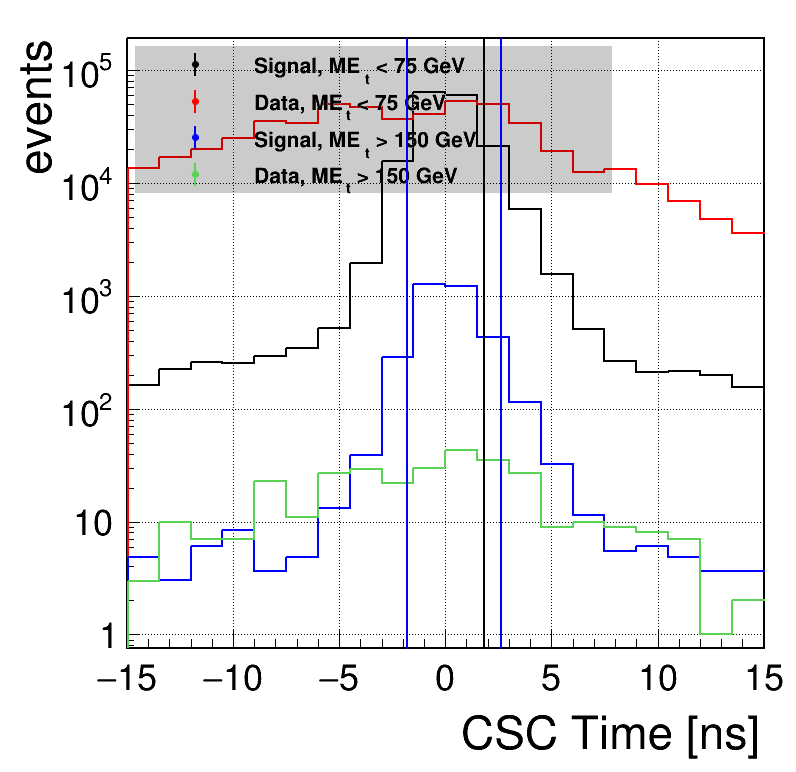

In [28]:
MIN_CSC_TIME_L, MAX_CSC_TIME_L = None, None
MIN_CSC_TIME_H, MAX_CSC_TIME_H = None, None

bins, log, norm = [20,-15,15], True, False
# bins, log, norm = [20,-10,10], False, True
axis_titles = ['CSC Time [ns]', f'{"fraction of " if norm else ""}events']
values = [ms['cscTimeWeighted'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# min_t, max_t = min([ak.min(v) for v in values]), max([ak.max(v) for v in values])
min_t, max_t = -15, 15

s2b_ll, s2b_hl, s2b_lr, s2b_hr = 0, 0, 0, 0
# for tc in np.arange(-20, 20+0.5, 0.5):
for tc in np.linspace(-20, 20, 100):
    # if abs(tc) < 2.5:
    #     continue

    if tc < 0:
        s = np.sum(weights[0] * (tc < values[0]) * (values[0] < 0))
        b = np.sum(weights[1] * (tc < values[1]) * (values[1] < 0))
        ps = np.mean(tc < values[0][values[0] < 0])
        pb = np.mean(tc < values[1][values[1] < 0])
        s2b = s / ( b**(1/2) )
        # s2b = np.log(ps) - np.log(pb)/2
        if s2b > s2b_ll and b > 0:
            s2b_ll, MIN_CSC_TIME_L = s2b, tc
        
        s = np.sum(weights[2] * (tc < values[2]) * (values[2] < 0))
        b = np.sum(weights[3] * (tc < values[3]) * (values[3] < 0))
        ps = np.mean(tc < values[2][values[2] < 0])
        pb = np.mean(tc < values[3][values[3] < 0])
        s2b = s / ( b**(1/2) )
        # s2b = np.log(ps) - np.log(pb)/2
        if s2b > s2b_hl and b > 0:
            s2b_hl, MIN_CSC_TIME_H = s2b, tc
        
    elif 0 < tc:
        s = np.sum(weights[0] * (0 < values[0]) * (values[0] < tc))
        b = np.sum(weights[1] * (0 < values[1]) * (values[1] < tc))
        ps = np.mean(tc > values[0][values[0] > 0])
        pb = np.mean(tc > values[1][values[1] > 0])
        s2b = s / ( b**(1/2) )
        # s2b = np.log(ps) - np.log(pb)/2
        if s2b > s2b_lr:
            s2b_lr, MAX_CSC_TIME_L = s2b, tc

        s = np.sum(weights[2] * (0 < values[2]) * (values[2] < tc))
        b = np.sum(weights[3] * (0 < values[3]) * (values[3] < tc))
        ps = np.mean(tc > values[2][values[2] > 0])
        pb = np.mean(tc > values[3][values[3] > 0])
        s2b = s / ( b**(1/2) )
        # s2b = np.log(ps) - np.log(pb)/2
        if s2b > s2b_hr and b > 0:
            s2b_hr, MAX_CSC_TIME_H = s2b, tc


print(f'{MIN_CSC_TIME_L=:.2f}, {MAX_CSC_TIME_L=:.2f}, {s2b_ll=:.2f}, {s2b_lr=:.2f}')
print(f'{MIN_CSC_TIME_H=:.2f}, {MAX_CSC_TIME_H=:.3f}, {s2b_hl=:.2f}, {s2b_hr=:.2f}')

lines = [rt.TLine(MIN_CSC_TIME_L, 0, MIN_CSC_TIME_L, hists[0].GetMaximum()),
         rt.TLine(MAX_CSC_TIME_L, 0, MAX_CSC_TIME_L, hists[0].GetMaximum()),
         rt.TLine(MIN_CSC_TIME_H, 0, MIN_CSC_TIME_H, hists[0].GetMaximum()),
         rt.TLine(MAX_CSC_TIME_H, 0, MAX_CSC_TIME_H, hists[0].GetMaximum())
]

for iline, line, in enumerate(lines):
    line.SetLineColor(hists[(iline//2)*2].GetLineColor())
    line.SetLineWidth(2)
    line.Draw()

canvas.Draw()

# DT Time

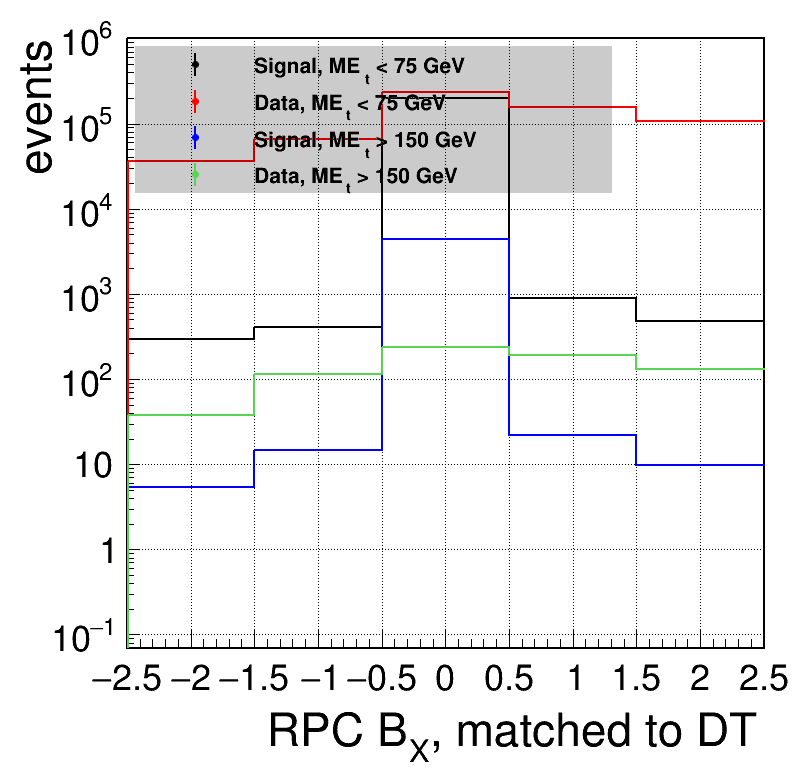

In [4]:
bins, log, norm = [5,-2.5,2.5], True, False
# bins, log, norm = [5,-2.5,2.5], False, True
axis_titles = ['RPC B_{X}, matched to DT', f'{"fraction of " if norm else ""}events']
values = [ms['dtRechitCluster_match_RPCBx_dPhi0p5'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

# DT MB1

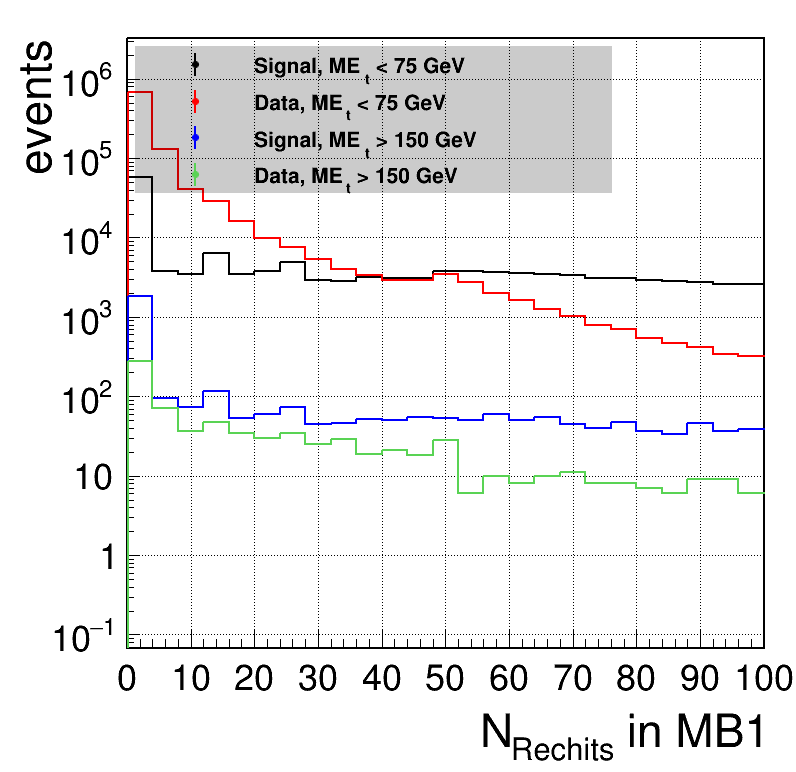

In [5]:
bins, log, norm = [25,0, 100], True, False
# bins, log, norm = [25,0, 100], False, True
axis_titles = ['N_{Rechits} in MB1', f'{"fraction of " if norm else ""}events']
values = [ms['dtNHitStation1'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

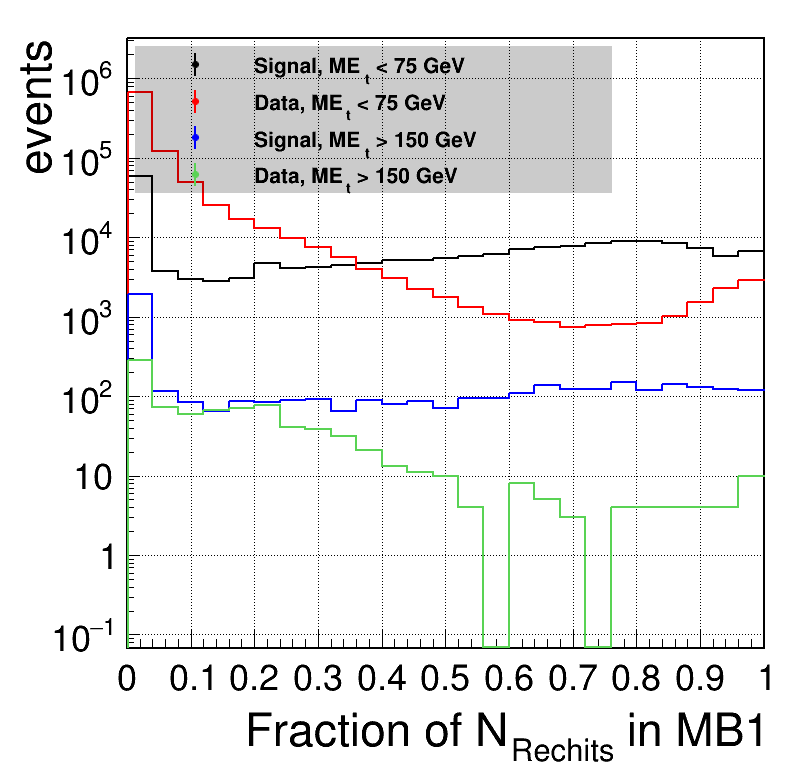

In [6]:
bins, log, norm = [25,0, 1], True, False
# bins, log, norm = [25,0, 1], False, True
axis_titles = ['Fraction of N_{Rechits} in MB1', f'{"fraction of " if norm else ""}events']
values = [ms['dtNHitStation1'] / ms['dtSize'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

# CSC Jet

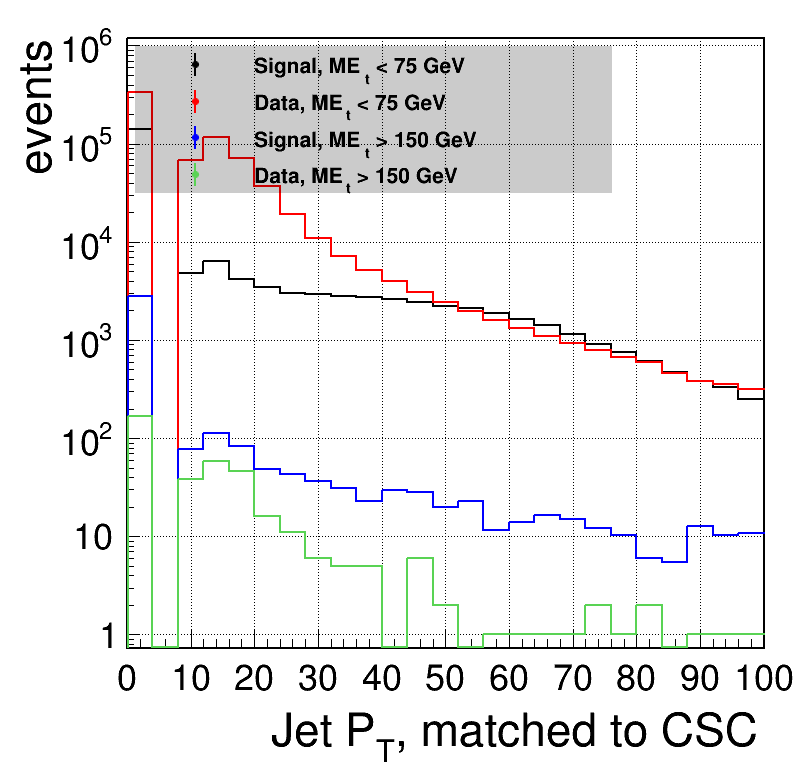

In [7]:
bins, log, norm = [25,0, 100], True, False
# bins, log, norm = [25,0, 100], False, True
axis_titles = ['Jet P_{T}, matched to CSC', f'{"fraction of " if norm else ""}events']
values = [ms['cscRechitClusterJetVetoPt'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

# DT Jet

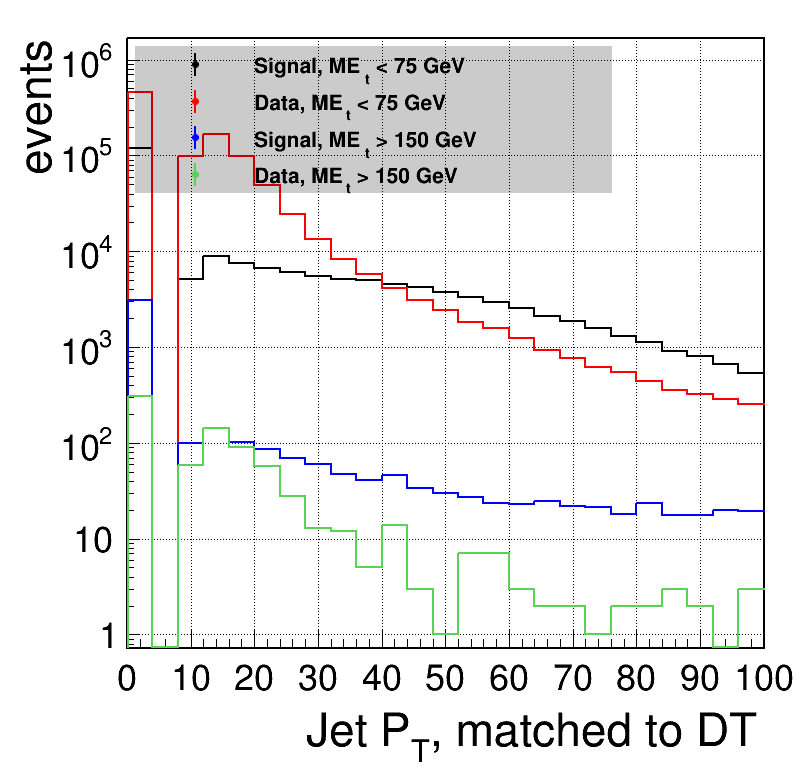

In [8]:
bins, log, norm = [25,0, 100], True, False
# bins, log, norm = [25,0, 100], False, True
axis_titles = ['Jet P_{T}, matched to DT', f'{"fraction of " if norm else ""}events']
values = [ms['dtRechitClusterJetVetoPt'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

# Halo